In [3]:
%pip install --upgrade pip
%pip install transformers torch torchvision
%pip install devinterp
%pip install numpy 

import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 
# if you want to use your TPU (note that torch_xla is not by default installed, install using pip install devinterp[tpu]) 
# import os 
# os.environ["USE_TPU_BACKEND"] = "1" 
# import torch_xla.core.xla_model as xm 
# DEVICE = xm.xla_device()

import warnings

import torch
import torchvision
from torch.nn import functional as F
from transformers import AutoModelForImageClassification

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

warnings.filterwarnings("ignore")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Vocab size: 29
d_model: 361
Max positions: 51


Chain 9: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]

dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])


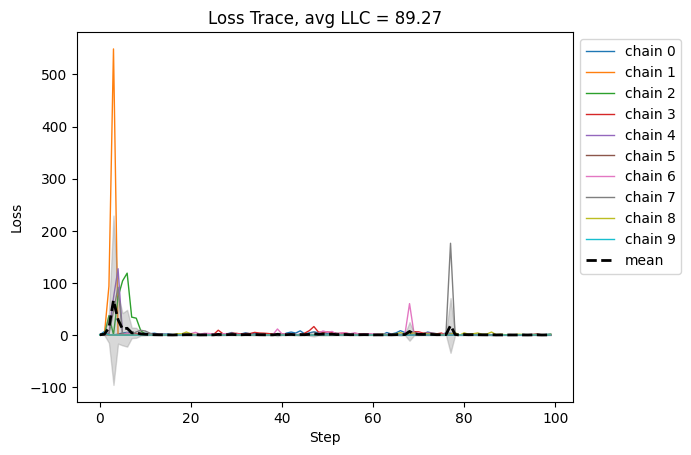

<Figure size 1200x900 with 0 Axes>

In [ ]:
from palindrome import check_palindrome
from tracr.haiku_to_pytorch import haiku_to_pytorch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

bos = "BOS"
init_model = check_palindrome() # CHANGE TO WHATEVER
base_model = haiku_to_pytorch(init_model)

init_vocab = ['a', 'b', 'c', 'd', 'e']
init_label = lambda data: int(list(data) == list(data)[::-1])
init_seq_len = 5

# Get vocab from the encoder's encoding_map
token_to_idx = init_model.input_encoder.encoding_map
vocab_list = list(token_to_idx.keys())
vocab_size = init_model.input_encoder.vocab_size
d_model = base_model.layers[0].attn.d_model

# Get actual max position from the Haiku model
max_pos = init_model.params['pos_embed']['embeddings'].shape[0]

print(f"Vocab size: {vocab_size}")
print(f"d_model: {d_model}")
print(f"Max positions: {max_pos}")

# Wrapper that adds proper embeddings
class TracrWithEmbeddings(nn.Module):
    def __init__(self, base_model, vocab_size, d_model, max_pos, token_to_idx, haiku_model):
        super().__init__()
        self.base_model = base_model
        self.token_to_idx = token_to_idx
        self.haiku_model = haiku_model
        
        # Create learnable embedding layers with correct sizes
        self.token_embed = nn.Embedding(vocab_size, d_model, dtype=torch.float64)
        self.pos_embed = nn.Embedding(max_pos, d_model, dtype=torch.float64)
        
        # Initialize with Haiku weights
        with torch.no_grad():
            token_emb_weights = torch.tensor(
                np.array(haiku_model.params['token_embed']['embeddings']),
                dtype=torch.float64
            )
            self.token_embed.weight.copy_(token_emb_weights)
            
            pos_emb_weights = torch.tensor(
                np.array(haiku_model.params['pos_embed']['embeddings']),
                dtype=torch.float64
            )
            self.pos_embed.weight.copy_(pos_emb_weights)
    
    def forward(self, x):
        # x is list of token sequences: [['BOS', 'a', 'b'], ...]
        
        # Convert to indices
        batch_indices = []
        for seq in x:
            indices = [self.token_to_idx[token] for token in seq]
            batch_indices.append(indices)
        
        # Convert to tensor
        x_indices = torch.tensor(batch_indices, dtype=torch.long, device=self.token_embed.weight.device)
        B, T = x_indices.shape
        
        # Get embeddings (these have gradients!)
        tok_emb = self.token_embed(x_indices)
        pos_emb = self.pos_embed(torch.arange(T, device=x_indices.device))
        x = tok_emb + pos_emb
        
        # Apply transformer layers from base model
        for layer in self.base_model.layers:
            x = layer(x)
        
        return x

# Add classification head wrapper
class TracrClassifier(nn.Module):
    def __init__(self, transformer, d_model, num_classes=2):
        super().__init__()
        self.transformer = transformer
        self.classifier = nn.Linear(d_model, num_classes, dtype=torch.float64)
        
        # Initialize classifier with small weights to prevent instability
        with torch.no_grad():
            self.classifier.weight.normal_(0, 0.01)
            self.classifier.bias.zero_()
    
    def forward(self, x):
        hidden = self.transformer(x)  # (batch, seq_len, d_model)
        pooled = hidden[:, -1, :]  # Use last token (batch, d_model)
        logits = self.classifier(pooled)  # (batch, num_classes)
        return logits

# Create model with classification head
base_transformer = TracrWithEmbeddings(base_model, vocab_size, d_model, max_pos, token_to_idx, init_model)
model = TracrClassifier(base_transformer, d_model, num_classes=2)

# Enable gradients
for param in model.parameters():
    param.requires_grad = True

model = model.to(DEVICE)

# Dataset
class GeneralDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, seq_len, num_samples):
        self.vocab = vocab
        self.seq_len = seq_len
        self.num_samples = num_samples
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Generate random sequence from vocab
        seq = [np.random.choice(self.vocab) for _ in range(self.seq_len)]
        
        # Label: 1 if palindrome, 0 otherwise 
        label = init_label(seq) #change to whatever labeling needed
        
        # Prepend BOS token
        full_seq = ["BOS"] + seq
        
        return full_seq, label

def custom_collate(batch):
    """Keep sequences as lists, batch only labels"""
    sequences, labels = zip(*batch)
    return list(sequences), torch.tensor(labels, dtype=torch.long)

# Create dataset and loader
vocab = init_vocab 
data = GeneralDataset(vocab=vocab, seq_len=init_seq_len, num_samples=10000) 
loader = torch.utils.data.DataLoader(data, batch_size=256, shuffle=True, collate_fn=custom_collate)

# Proper evaluate function with cross-entropy loss
def evaluate(model, batch):
    sequences, labels = batch  
    labels = labels.to(DEVICE)
    
    # Get logits from model
    logits = model(sequences)  # (batch, 2)
    
    # Check for NaN/inf in logits before computing loss
    if torch.isnan(logits).any() or torch.isinf(logits).any():
        print("NaN/Inf in logits!")
        print("Logits stats - min:", logits.min().item(), "max:", logits.max().item())
        return torch.tensor(float('inf'), device=DEVICE)
    
    # Compute proper cross-entropy loss
    loss = F.cross_entropy(logits, labels)
    
    # Debug NaN if it occurs
    if torch.isnan(loss):
        print("NaN in loss!")
        print("Logits:", logits[:5])
        print("Labels:", labels[:5])
    
    return loss

learning_coeff_stats = estimate_learning_coeff_with_summary(
    model,
    loader=loader,
    evaluate=evaluate,
    sampling_method=SGLD,
    optimizer_kwargs=dict(
        lr=1e-5,  # Much lower learning rate
        localization=100.0, 
        nbeta=default_nbeta(loader)
    ),
    num_chains=10,
    num_draws=100,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    device=DEVICE,
    online=True,
)

trace = learning_coeff_stats["loss/trace"]
print(learning_coeff_stats.keys())

plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)
print(learning_coeff_stats['llc/means'])